# ProWave - WaveNet-based Protein Generation

Authors: Hans Jakob Damsgaard & Lucas Balling

02456 Deep Learning project: ProGen

## Initialization

Run the commmand below if you have not yet installed the [TAPE project](https://github.com/songlab-cal/tape).

In [1]:
#!pip install tape_proteins

#### Importing needed packages

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.nn.parameter import Parameter
import tape

#### Import the data

We were unable to make the data download script, `download_data.sh`, run from Jupyter, so instead we ran it manually and simply placed the resulting files in the right folder for TAPE to find them. We import all the data in the LMDB format as it is most easily worked with in Python.

In [4]:
from tape.datasets import LanguageModelingDataset

# Data stored under `<data-path>/data`
#data_path = '/Users/lucasballing/Desktop/DeepLearningProject/prowave-main/data/'
data_path = 'E:/Pfam/data/'
train_data   = LanguageModelingDataset(data_path, 'train')
valid_data   = LanguageModelingDataset(data_path, 'valid')
holdout_data = LanguageModelingDataset(data_path, 'holdout')

#### Understanding data features

To get a good understanding of the data provided in the imported dataset, we provide plots of certain features and their ranges. Data is already split into the three required subsets; train, validation, and holdout by TAPE, so it is also interesting to understand this split.

In [38]:
# Split sizes
print(f'Training data has shape ({len(train_data)}, {len(train_data[0])})')
print(f'Validation data has shape ({len(valid_data)}, {len(valid_data[0])})')
print(f'Holdout data has shape ({len(holdout_data)}, {len(holdout_data[0])})')

# Original data columns
from tape.datasets import LMDBDataset
lmdb_train = LMDBDataset(data_path+'pfam/pfam_train.lmdb')
print(f'File data entries look like this: {lmdb_train[0]}')
del lmdb_train

# Data columns - all subsets are taken from the same overall dataset, so the columns are the same
# From combining information from LMDBDataset and LanguageModelingDataset, we know the columns are
# - IUPAC-encoded protein string
# - Input mask (for masked-token prediction)
# - Protein clan
# - Protein family
# The protein ID (i.e., its number within its clan and family) is not included
print(f'Encoded data entries look like this: {train_data[0]}')

Training data has shape (32593668, 4)
Validation data has shape (1715454, 4)
Holdout data has shape (44311, 4)
File data entries look like this: {'primary': 'GCTVEDRCLIGMGAILLNGCVIGSGSLVAAGALITQ', 'protein_length': 36, 'clan': 433, 'family': 9122, 'id': '0'}
Encoded data entries look like this: (array([ 2, 11,  7, 23, 25,  9,  8, 21,  7, 15, 13, 11, 16, 11,  5, 13, 15,
       15, 17, 11,  7, 25, 13, 11, 22, 11, 22, 15, 25,  5,  5, 11,  5, 15,
       13, 23, 20,  3], dtype=int64), array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64), 433, 9122)


In [22]:
# def setify(data, param = 2):
#     res = set()
#     for i in range(len(data)):
#         res.add(data[i][param])
#     return res
# 
# # Clans in splits
# print(f'Unique clans in training data {len(setify(train_data))}')
# print(f'Unique clans in validation data {len(setify(valid_data))}')
# print(f'Unique clans in holdout data {len(setify(holdout_data))}')
# 
# # Families in splits
# print(f'Unique families in training data {len(setify(train_data, 3))}')
# print(f'Unique families in validation data {len(setify(valid_data, 3))}')
# print(f'Unique families in holdout data {len(setify(holdout_data, 3))}')


In [93]:
from tape.datasets import LMDBDataset
data_path = '/Users/lucasballing/Desktop/DeepLearningProject/prowave-main/data/pfam/pfam_holdout.lmdb' # 'Your File Path here'


np.train_datav2 = np.array(LMDBDataset(data_path))
train_datav3 = (LMDBDataset(data_path))
print("Size of Dataset",train_data[2][3] )

Size of Dataset 1464


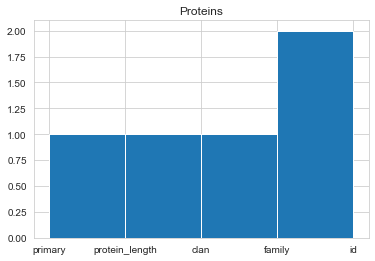

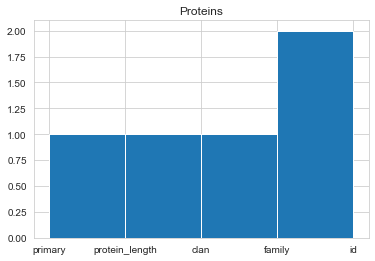

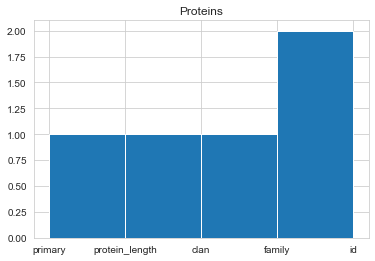

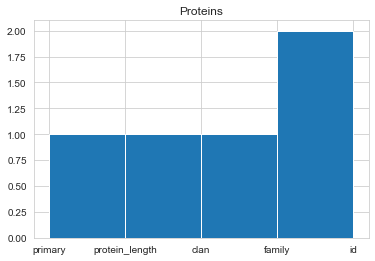

Size of Dataset:  44311
Dataset looks like this   [{'primary': 'DNEDNKKVYVAQNYDMEKYYKDYITLIKIKERETDTLLITFAGVLGCIGFNSCGIGLNINYLQANDLGTGILYPFVVRKALQQNRIGDALGAITTGFKASGMNYLLSDSLGNIFDIEMAGKDFDILQMKDGFMSHSNHYKSEKLIKKDMMAYDLSLDSSFSRRGSTIIREHVCNKLLNKRKESFVLEDIKNILTDHTNYPYSICKHGDLNEDKYRGNETVFSSIFDLESREAHIAIGTPCK', 'protein_length': 241, 'clan': 34, 'family': 153, 'id': '0'}
 {'primary': 'QIGAGGTLLRNYDFSPDGCEGTIVSSHFLRPVIGMQDAAWGLLDGMNDAGLAVSLTFGGRFVHGPGFAVLIVLRYLLETCTTVGEAVGKLKSLPIAIPQNVTLVDPERSLTVFVGPDIPLTEAPDACAANHQHLPVPDEQEQSSRTQERLSAIRAAGTDVAAMLEPPLYQTAYDEWLGTLYTAHYRPSEGRVTYYWPGDSW', 'protein_length': 201, 'clan': 34, 'family': 153, 'id': '1'}
 {'primary': 'VLTGKEIQLVRNYDYHPDLMEGTQLLSAWNGKKVIATSDCLIGAVDGMNEDGLAISLTFGGRKEVGVGFGIPFILRYVLEFCSNAEEAVEALIRIPSHMSYNVTVVDKTGAYKTVRMAPDREPVVTDAAFATNHQGTVDWPENAAFNKTIERSAYIEKMLTKKGIKAQAVADAFLKKPLYNTLFKEGFGTLFTAVYRPAEGTVETRWPNAS', 'protein_length': 211, 'clan': 34, 'family': 153, 'id': '2'}
 ...
 {'primary': 'PWSQDTFLARLRTFSRVSLWHPKPQSISEVKWAKRGWSCVDVNT

In [96]:
_ = plt.hist(np.train_datav2[2], bins='auto')  # arguments are passed to np.histogram
plt.title("Proteins")
plt.Text(0.5, 1.0, "Histogram with 'auto' bins")
plt.show()

_ = plt.hist(np.train_datav2[5], bins='auto')  # arguments are passed to np.histogram
plt.title("Proteins")
plt.Text(0.5, 1.0, "Histogram with 'auto' bins")
plt.show()

_ = plt.hist(np.train_datav2[4], bins='auto')  # arguments are passed to np.histogram
plt.title("Proteins")
plt.Text(0.5, 1.0, "Histogram with 'auto' bins")
plt.show()

_ = plt.hist(train_datav3[1], bins='auto')  # arguments are passed to np.histogram
plt.title("Proteins")
plt.Text(0.5, 1.0, "Histogram with 'auto' bins")
plt.show()

print("Size of Dataset: ",np.size(np.train_datav2) )
print("Dataset looks like this  ",(np.train_datav2) )


# Not Numpy array

print("Size of Dataset: ",np.size(train_datav3) )
print("Dataset looks like this  ",(train_datav3) )

In [90]:
print("Dataset looks like this  ",(np.train_datav2[1]) )
print("Dataset looks like this  ",(np.train_datav2[2]) )


Dataset looks like this   {'primary': 'QIGAGGTLLRNYDFSPDGCEGTIVSSHFLRPVIGMQDAAWGLLDGMNDAGLAVSLTFGGRFVHGPGFAVLIVLRYLLETCTTVGEAVGKLKSLPIAIPQNVTLVDPERSLTVFVGPDIPLTEAPDACAANHQHLPVPDEQEQSSRTQERLSAIRAAGTDVAAMLEPPLYQTAYDEWLGTLYTAHYRPSEGRVTYYWPGDSW', 'protein_length': 201, 'clan': 34, 'family': 153, 'id': '1'}
Dataset looks like this   {'primary': 'VLTGKEIQLVRNYDYHPDLMEGTQLLSAWNGKKVIATSDCLIGAVDGMNEDGLAISLTFGGRKEVGVGFGIPFILRYVLEFCSNAEEAVEALIRIPSHMSYNVTVVDKTGAYKTVRMAPDREPVVTDAAFATNHQGTVDWPENAAFNKTIERSAYIEKMLTKKGIKAQAVADAFLKKPLYNTLFKEGFGTLFTAVYRPAEGTVETRWPNAS', 'protein_length': 211, 'clan': 34, 'family': 153, 'id': '2'}


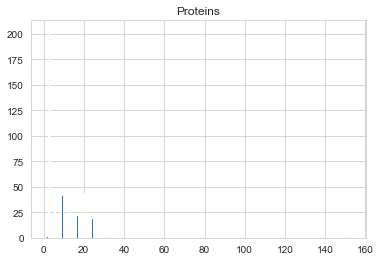

In [99]:
#Holdout data language model
_ = plt.hist(np.holdout_data[1], bins='auto')  # arguments are passed to np.histogram
plt.title("Proteins")
plt.Text(0.5, 1.0, "Histogram with 'auto' bins")
plt.show()


In [100]:
print("Dataset looks like this  ",(np.holdout_data[2]) )

Dataset looks like this   (array([ 2, 25, 15, 23, 11, 14,  9, 13, 20, 15, 25, 21, 17, 28,  8, 28, 12,
       19,  8, 15, 16,  9, 11, 23, 20, 15, 15, 22,  5, 26, 17, 11, 14, 14,
       25, 13,  5, 23, 22,  8,  7, 15, 13, 11,  5, 25,  8, 11, 16, 17,  9,
        8, 11, 15,  5, 13, 22, 15, 23, 10, 11, 11, 21, 14,  9, 25, 11, 25,
       11, 10, 11, 13, 19, 10, 13, 15, 21, 28, 25, 15,  9, 10,  7, 22, 17,
        5,  9,  9,  5, 25,  9,  5, 15, 13, 21, 13, 19, 22, 12, 16, 22, 28,
       17, 25, 23, 25, 25,  8, 14, 23, 11,  5, 28, 14, 23, 25, 21, 16,  5,
       19,  8, 21,  9, 19, 25, 25, 23,  8,  5,  5, 10,  5, 23, 17, 12, 20,
       11, 23, 25,  8, 26, 19,  9, 17,  5,  5, 10, 17, 14, 23, 13,  9, 21,
       22,  5, 28, 13,  9, 14, 16, 15, 23, 14, 14, 11, 13, 14,  5, 20,  5,
       25,  5,  8,  5, 10, 15, 14, 14, 19, 15, 28, 17, 23, 15, 10, 14,  9,
       11, 10, 11, 23, 15, 10, 23,  5, 25, 28, 21, 19,  5,  9, 11, 23, 25,
        9, 23, 21, 26, 19, 17,  5, 22,  3]), array([1, 1, 1, 1, 1, 1, 1, 

In [102]:

import pandas as pd

df = pd.DataFrame(np.holdout_data)

ValueError: DataFrame constructor not properly called!